### Libraries

In [304]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

#Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../olds/prueba_csv.csv",
        "trainingSize": .60,
        "validationSize": .2,
        "testSize": .2
    },
    "validation": {
        "n_splits" : 6
    }
}

In [305]:
def plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=y_train, mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_val_dates, y=y_val, mode="lines", name="Validation"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=y_test, mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (kWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.show()

In [306]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

In [307]:
def permutation_feature_importance(model, X_test, y_test, feature_names):
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42) 
    y_pred = model.predict(X_test)

    #rmse_ref = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae_ref = mean_absolute_error(y_test, y_pred)

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted)

        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(y_test, y_pred_permuted)

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()


In [308]:
def addNLags(df, lags=1):
    lag_df= df.copy()
    for i in range(1, lags + 1):
        lag_df[f'lag_{i}'] = lag_df["Demand"].shift(i * 24).fillna(0)

    return lag_df.fillna(0)

In [309]:
def normalizeData(data):
    df = data.copy()
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

## Machine Learning Models

### Split Dataset

In [310]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)

df = addNLags(df, 20)
df = df.drop(columns=["Date"], axis=1)

y = df["Demand"]
X = df.drop(columns=["Demand"], axis=1)
col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Validation Size:{len(X_val)}")
print(f"Test Size: {len(X_test)}")
df.columns

Total Lags: 46753
Training Size:28052
Validation Size:9351
Test Size: 9352


Index(['pres', 'slp', 'wind_dir', 'wind_gust_spd', 'wind_spd', 'temp', 'rh',
       'dewpt', 'clouds', 'vis', 'precip', 'dhi', 'dni', 'ghi', 'solar_rad',
       'uv', 'elev_angle', 'az', 'Temp interna Modulo', 'Year', 'Month',
       'Hour', 'DayOfWeek', 'DayOfYear', 'Demand', 'Season', 'isWeekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'isHoliday'],
      dtype='object')

In [311]:
plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test)

### Models to Test

In [312]:
models, models_names = [], []

#Tree Models
for n in [1000]:
    LGBM = LGBMRegressor(boosting_type='gbdt', n_estimators=n, learning_rate=0.01, random_state=123, n_jobs=-1, verbose=0)
    XGB = XGBRegressor(n_estimators=n, random_state=123, learning_rate=0.01, max_depth=5)
    GBM = GradientBoostingRegressor(n_estimators=n, learning_rate=0.01, random_state=123)
    models.append(LGBM)
    models_names.append("LGBM_" + str(n))
    models.append(XGB)
    models_names.append("XGB_" + str(n))
    #models.append(GBM)
    #models_names.append("GBM_" + str(n))

for n in [10, 20, 30]:
    KNN = KNeighborsRegressor(n_neighbors=n, weights='uniform')
    models.append(KNN)
    models_names.append("KNNr_" + str(n) + "_" + 'uniform')

### Walking Forward Validation

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*lmUY2pKwxu5kwA1II6yAbQ.png" width=600px></img>
</div>


In [313]:
def walkForwardValidation(X, y, X_test, y_test, models, models_names, params, plot=False, fixed_train=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val","Mean_MRSE_Test", "Mean_MAE_Test", "Mean_RMSE_Val", "Mean_MAE_Val"])
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_test2 = X_test.copy()
        X2 = X.copy()
            
        if fixed_train:
            tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=X.shape[0] // n_splits)
        else:
            tscv = TimeSeriesSplit(n_splits=n_splits)
        rmse_test, rmse_val, mae_test, mae_val = [], [], [], []
        for i, (train_index, eval_index) in enumerate(tscv.split(X2)):
            X_train, X_val = X2[train_index], X2[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            model.fit(X=X_train, y=y_train)

            #Validation Scores
            y_pred_val = model.predict(X_val)
            mae_val.append(mean_absolute_error(y_val, y_pred_val))
            rmse_val.append(root_mean_squared_error(y_val, y_pred_val))
            
            #Test Scores
            y_pred_test = model.predict(X_test2)
            mae_test.append(mean_absolute_error(y_test, y_pred_test))
            rmse_test.append(root_mean_squared_error(y_test, y_pred_test))
            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, np.mean(rmse_test), np.mean(mae_test), np.mean(rmse_val), np.mean(mae_val)] 
    
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "RMSE_Test", "MAE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        for i in range(4):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 2
            col = i % 2
            ax = axes[row, col]
            for index, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend()
            ax.grid(True)
        if fixed_train:
            plt.savefig('../results/Sliding_Window_Validation_plot.png')
        else:
            plt.savefig('../results/Walking_Forward_Validation_plot.png')
        plt.tight_layout()
        plt.show()
    return results

 20%|██        | 1/5 [00:35<02:22, 35.53s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.8935843771591365, RMSE: 3.5175477819951233


 40%|████      | 2/5 [01:16<01:56, 38.90s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.969246949388306, RMSE: 3.546617492902573


 60%|██████    | 3/5 [01:24<00:49, 24.67s/it]

Model: KNNr_10_uniform ===> Mean Test MAE: 2.1893359406187627, RMSE: 3.9495268732241695


 80%|████████  | 4/5 [01:32<00:18, 18.06s/it]

Model: KNNr_20_uniform ===> Mean Test MAE: 2.1707067008839465, RMSE: 3.835265618338102


100%|██████████| 5/5 [01:40<00:00, 20.02s/it]

Model: KNNr_30_uniform ===> Mean Test MAE: 2.175764226903336, RMSE: 3.800780607324405


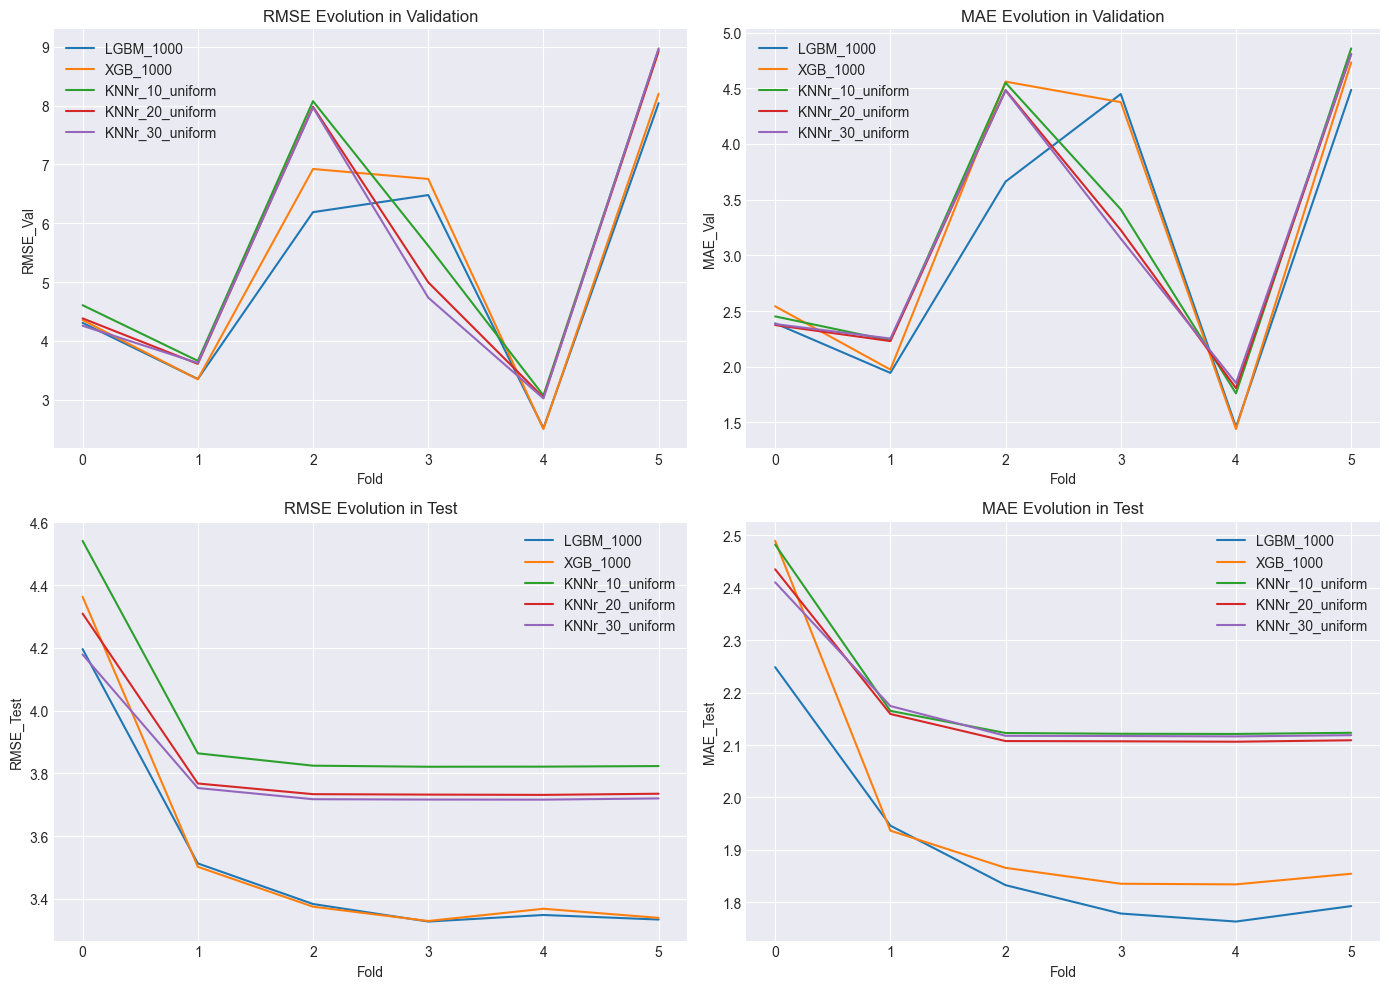

In [314]:
results = walkForwardValidation(pd.concat([X_train, X_val], axis=0).to_numpy(), pd.concat([y_train, y_val], axis=0).to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=False)
results.to_csv("../results/Walking_Forward_Validation.csv", index=None)

### Sliding Window Validation

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*M3WnQy2H4GFtTctSgvQ48g.png" width=600px>
</div>

 20%|██        | 1/5 [00:28<01:52, 28.01s/it]

Model: LGBM_1000 ===> Mean Test MAE: 2.3279086569419127, RMSE: 3.8985635445521165


 40%|████      | 2/5 [01:00<01:32, 30.80s/it]

Model: XGB_1000 ===> Mean Test MAE: 2.4149842754918045, RMSE: 3.906679689050238


 60%|██████    | 3/5 [01:03<00:36, 18.09s/it]

Model: KNNr_10_uniform ===> Mean Test MAE: 2.847779606857712, RMSE: 4.856353578743931


 80%|████████  | 4/5 [01:06<00:12, 12.19s/it]

Model: KNNr_20_uniform ===> Mean Test MAE: 2.6652303571428573, RMSE: 4.453743420870066


100%|██████████| 5/5 [01:10<00:00, 14.00s/it]

Model: KNNr_30_uniform ===> Mean Test MAE: 2.5881868269413553, RMSE: 4.292721485890496


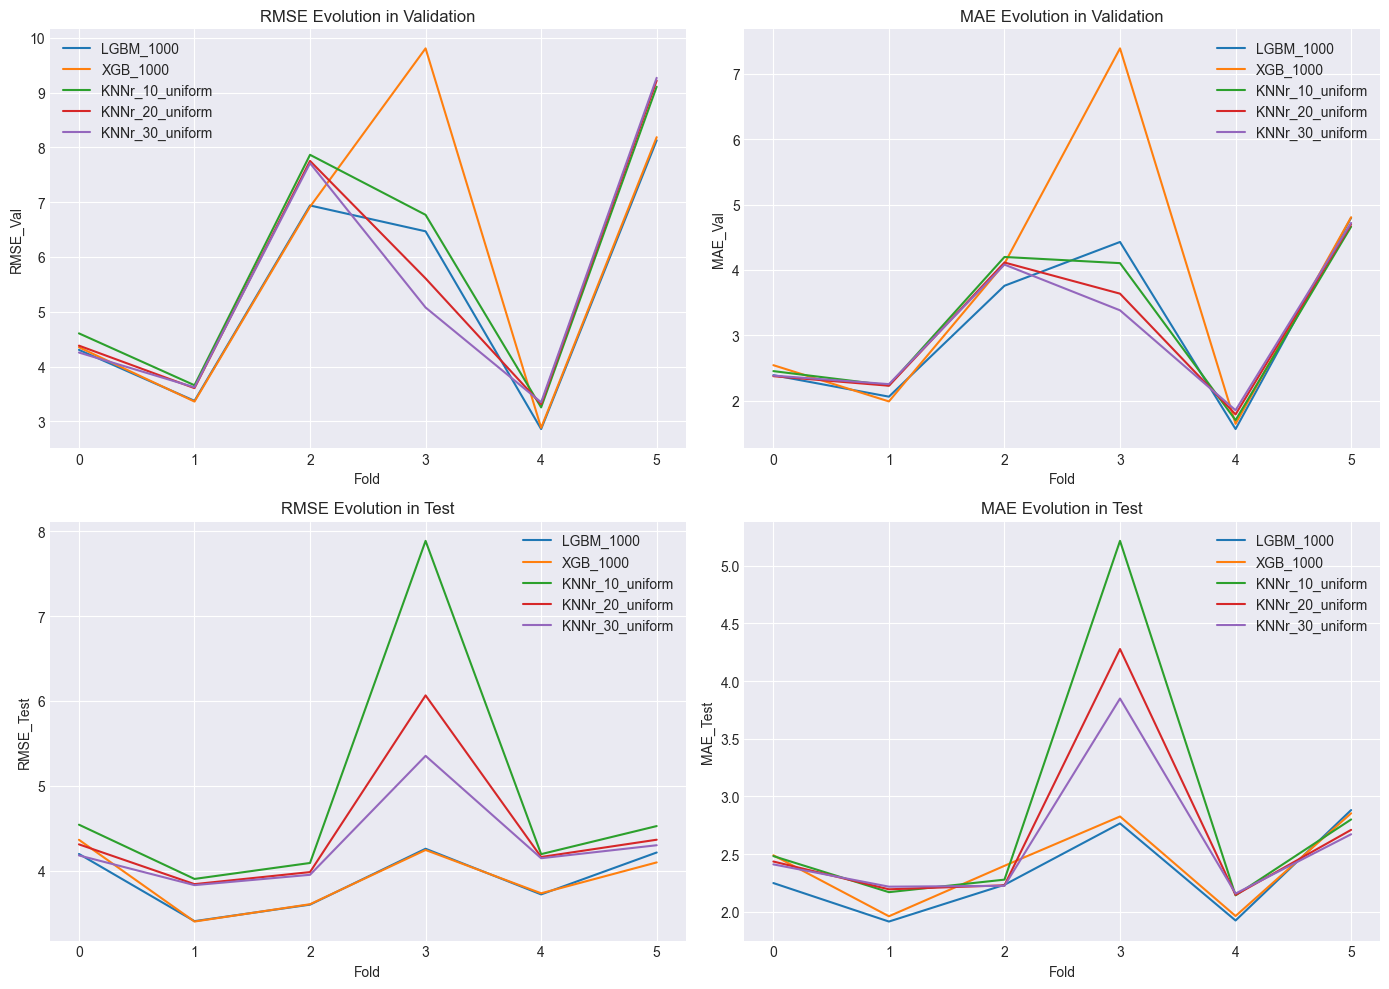

In [315]:
results = walkForwardValidation(pd.concat([X_train, X_val], axis=0).to_numpy(), pd.concat([y_train, y_val], axis=0).to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=True)
results.to_csv("../results/Sliding_Window_Validation.csv", index=None)

### Quantile Transformation

In [316]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)
quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42) 
df["Demand"] = quantile_transformer.fit_transform(df["Demand"].values.reshape(-1, 1)).flatten() 

#df = addNLags(df, 20)
df = df.drop(columns=["Date"], axis=1)

y = df["Demand"]
X = df.drop(columns=["Demand"], axis=1)
col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Validation Size:{len(X_val)}")
print(f"Test Size: {len(X_test)}")
df.columns


Total Lags: 46753
Training Size:28052
Validation Size:9351
Test Size: 9352


Index(['pres', 'slp', 'wind_dir', 'wind_gust_spd', 'wind_spd', 'temp', 'rh',
       'dewpt', 'clouds', 'vis', 'precip', 'dhi', 'dni', 'ghi', 'solar_rad',
       'uv', 'elev_angle', 'az', 'Temp interna Modulo', 'Year', 'Month',
       'Hour', 'DayOfWeek', 'DayOfYear', 'Demand', 'Season', 'isWeekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'isHoliday'],
      dtype='object')

In [317]:
def walkForwardValidationQuant(X, y, X_test, y_test, models, models_names, params, plot=False, fixed_train=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val","Mean_MRSE_Test", "Mean_MAE_Test", "Mean_RMSE_Val", "Mean_MAE_Val"])
    y_test =quantile_transformer.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_test2 = X_test.copy()
        X2 = X.copy()
            
        if fixed_train:
            tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=X.shape[0] // n_splits)
        else:
            tscv = TimeSeriesSplit(n_splits=n_splits)
        rmse_test, rmse_val, mae_test, mae_val = [], [], [], []
        for i, (train_index, eval_index) in enumerate(tscv.split(X2)):
            X_train, X_val = X2[train_index], X2[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            model.fit(X=X_train, y=y_train)

            #Validation Scores
            y_pred_val = model.predict(X_val)
            y_pred_val = quantile_transformer.inverse_transform(y_pred_val.reshape(-1, 1)).flatten()
            y_val = quantile_transformer.inverse_transform(y_val.reshape(-1, 1)).flatten()

            mae_val.append(mean_absolute_error(y_val, y_pred_val))
            rmse_val.append(root_mean_squared_error(y_val, y_pred_val))
            
            #Test Scores
            y_pred_test = model.predict(X_test2)
            y_pred_test =quantile_transformer.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
            mae_test.append(mean_absolute_error(y_test, y_pred_test))
            rmse_test.append(root_mean_squared_error(y_test, y_pred_test))
            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, np.mean(rmse_test), np.mean(mae_test), np.mean(rmse_val), np.mean(mae_val)] 
    
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "RMSE_Test", "MAE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        for i in range(4):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 2
            col = i % 2
            ax = axes[row, col]
            for index, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend()
            ax.grid(True)
        if fixed_train:
            plt.savefig('../results/Sliding_Window_Validation_Quant_plot.png')
        else:
            plt.savefig('../results/Walking_Forward_Validation_Quant_plot.png')
        plt.tight_layout()
        plt.show()
    return results

 20%|██        | 1/5 [00:39<02:39, 39.84s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.7098596999793483, RMSE: 3.6798815911682756


 40%|████      | 2/5 [01:19<01:58, 39.65s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.7178570479544473, RMSE: 3.7223447223533803


 60%|██████    | 3/5 [01:26<00:49, 24.86s/it]

Model: KNNr_10_uniform ===> Mean Test MAE: 2.0746577149902135, RMSE: 4.164681019810538


 80%|████████  | 4/5 [01:34<00:18, 18.03s/it]

Model: KNNr_20_uniform ===> Mean Test MAE: 2.0524647016777426, RMSE: 4.164690862169507


100%|██████████| 5/5 [01:41<00:00, 20.35s/it]


Model: KNNr_30_uniform ===> Mean Test MAE: 2.0471894134791664, RMSE: 4.177006580655496


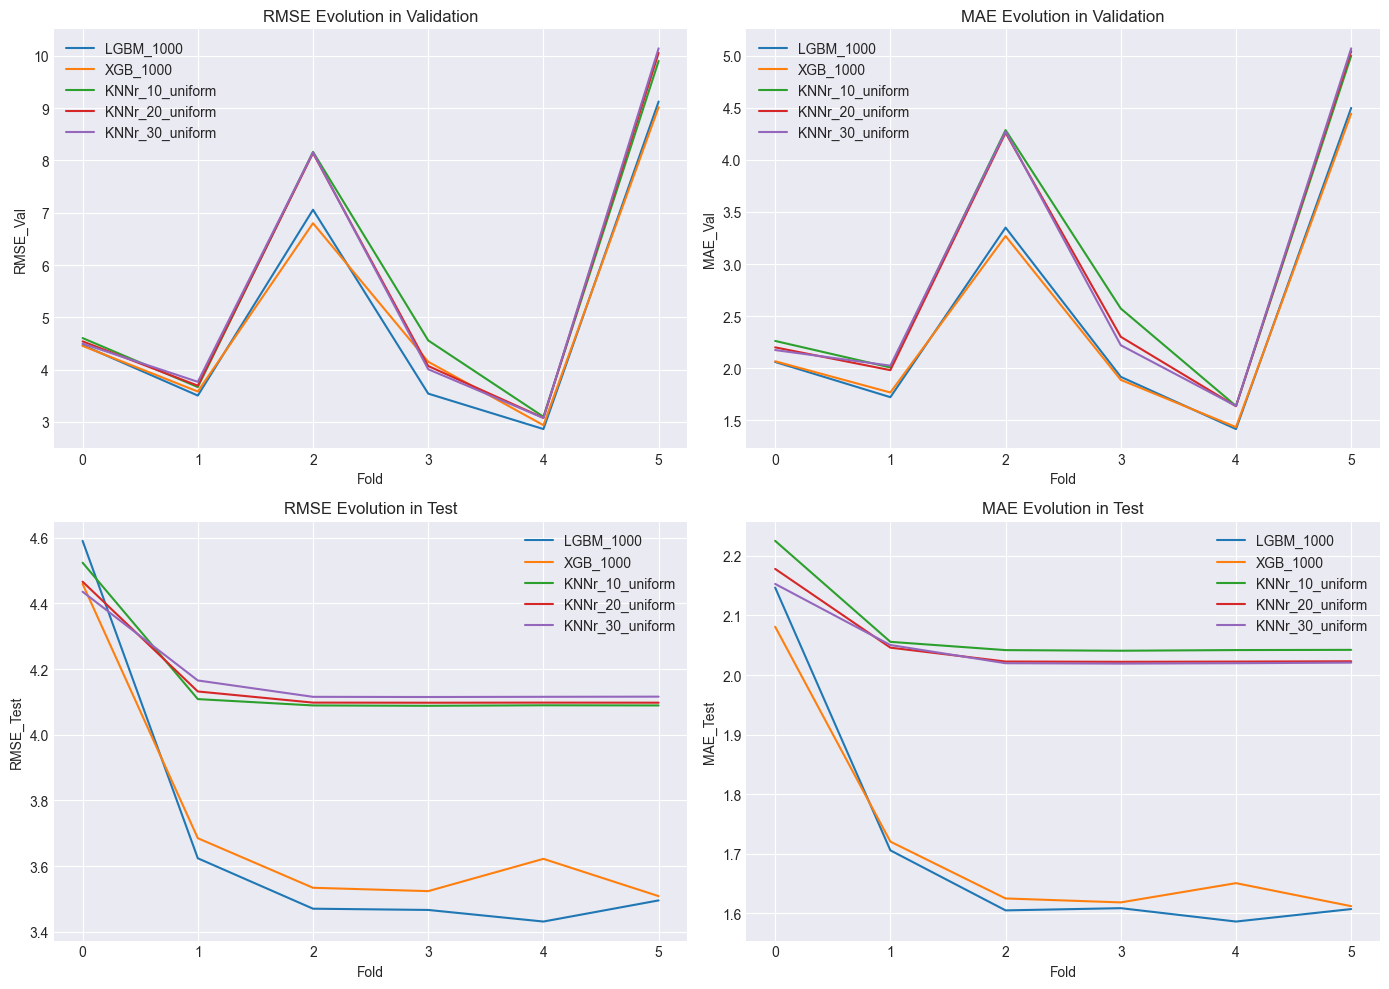

In [318]:
results = walkForwardValidationQuant(pd.concat([X_train, X_val], axis=0).to_numpy(), pd.concat([y_train, y_val], axis=0).to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=False)
results.to_csv("../data/Processed_Data/Walking_Forward_Validation_Quant.csv", index=None)

 20%|██        | 1/5 [00:28<01:54, 28.56s/it]

Model: LGBM_1000 ===> Mean Test MAE: 2.007785913972969, RMSE: 4.066233251808064


 40%|████      | 2/5 [00:56<01:25, 28.38s/it]

Model: XGB_1000 ===> Mean Test MAE: 2.006997187815809, RMSE: 4.058673676598466


 60%|██████    | 3/5 [00:59<00:33, 16.80s/it]

Model: KNNr_10_uniform ===> Mean Test MAE: 2.3869962033297627, RMSE: 4.5164164903929125


 80%|████████  | 4/5 [01:02<00:11, 11.41s/it]

Model: KNNr_20_uniform ===> Mean Test MAE: 2.2337735907636476, RMSE: 4.296276182767987


100%|██████████| 5/5 [01:06<00:00, 13.23s/it]

Model: KNNr_30_uniform ===> Mean Test MAE: 2.2004659145985954, RMSE: 4.272818289399773


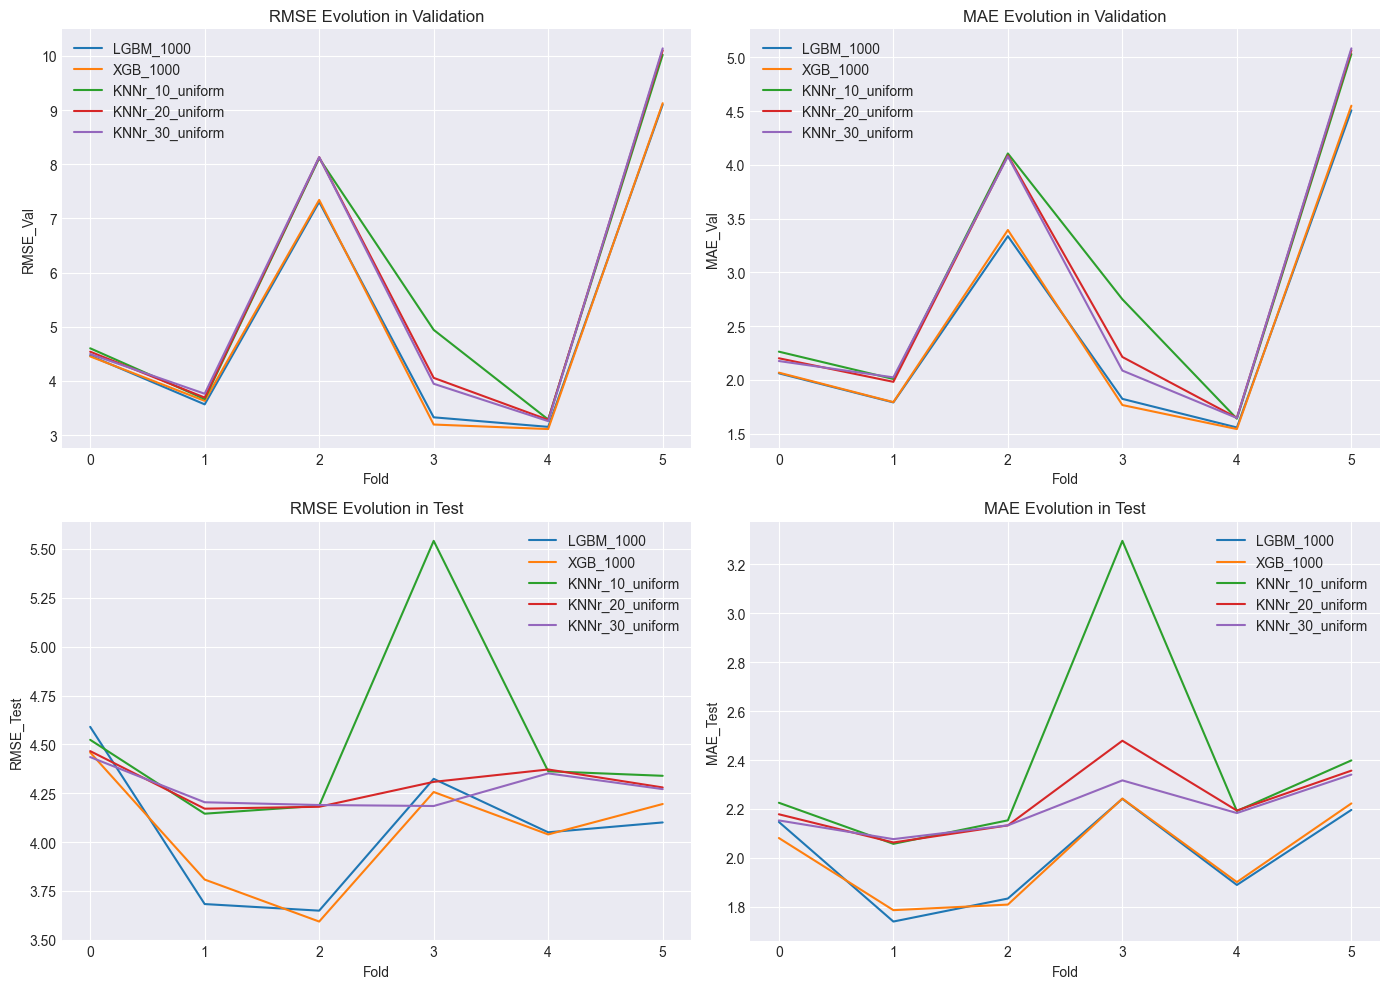

In [319]:
results = walkForwardValidationQuant(pd.concat([X_train, X_val], axis=0).to_numpy(), pd.concat([y_train, y_val], axis=0).to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=True)
results.to_csv("../data/Processed_Data/Sliding_Window_Validation_Quant.csv", index=None)

### Grid Search (XGBOOST)

In [320]:
params = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.01],
    'gamma': [3, 5],
    'colsample_bytree' : [0.5, 0.6, 0.7, 0.8],
    'colsample_bynode': [0.5, 0.7, 0.9, 1],
    'n_estimators': [1100]
}

def gridSearchXGB(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        max_depth = param.get('max_depth')
        n_estimators = param.get('n_estimators')
        lr = param.get('learning_rate')
        gamma = param.get('gamma')
        colsample_bytree = param.get('colsample_bytree')
        colsample_bynode = param.get('colsample_bynode')
        regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=n_estimators, learning_rate = lr, max_depth=max_depth, colsample_bytree = colsample_bytree, colsample_bynode = colsample_bynode, gamma=gamma, random_state=123, eval_metric='mae', early_stopping_rounds=100)

        regressorXGBR.fit(
            X = X_train,
            y = y_train,
            eval_set=[(X_val, y_val)],
            verbose=0
        )  
        y_pred = regressorXGBR.predict(X_test)
        y_pred = quantile_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Max_depth: {max_depth}, Gamma: {gamma}, Col_Sample_By_Tree: {colsample_bytree}, Col_Sample_By_Node: {colsample_bynode}")
    config["mae"] = best_mae
    return config

#gridSearchXGB(params)

### Grid Search (LightGBM)

In [321]:
params = {
    'num_leaves': [10, 20, 30, 40],
    'learning_rate': [0.05, 0.01, 0.005],
    'colsample_bytree' : [0.7, 0.9, 1],
    'n_estimators': [1200],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
}

def gridSearchLGBM(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        n_estimators = param.get('n_estimators')
        num_leaves = param.get('num_leaves')
        lr = param.get('learning_rate')
        reg_alpha = param.get('reg_alpha')
        colsample_bytree = param.get('colsample_bytree')
        LGBMReg = LGBMRegressor(boosting_type='gbdt', n_estimators=n_estimators, learning_rate=lr, random_state=123, reg_alpha=reg_alpha, n_jobs=-1, verbose=-1, early_stopping_rounds=100, num_leaves=num_leaves) 
        LGBMReg.fit(
            X = X_train,
            y = y_train,
            eval_set=[(X_val, y_val)]
        )  
        y_pred = LGBMReg.predict(X_test)
        y_pred = quantile_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Num_leaves: {num_leaves}, Col_Sample_By_Tree: {colsample_bytree}, reg_alpha: {reg_alpha}")
    config["mae"] = best_mae
    return config
#gridSearchLGBM(params)

### Feature Importance 

In [322]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1500, learning_rate = 0.01, max_depth=7, colsample_bytree = 0.7, colsample_bynode = 0.7, gamma=7, random_state=123, eval_metric='mae', early_stopping_rounds=100)
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    eval_set=[(X_val, y_val)],
    verbose=0
)

y_pred = regressorXGBR.predict(X_test)
y_pred = quantile_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}")

imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=regressorXGBR.feature_names_in_, columns=['importance'])
imp_df.sort_values(by=["importance"])

MAE: 3.9786472218366913, RMSE: 4.526346902999348


importance
vis                    0.006320
wind_gust_spd          0.006634
lag_18                 0.006678
wind_spd               0.006766
wind_dir               0.006923
rh                     0.006997
lag_17                 0.007304
lag_10                 0.007362
lag_11                 0.007590
lag_5                  0.007678
lag_9                  0.007753
lag_7                  0.007759
lag_13                 0.007895
pres                   0.007927
lag_19                 0.007999
slp                    0.008118
lag_14                 0.008462
precip                 0.008617
lag_6                  0.008636
lag_2                  0.008811
lag_15                 0.008928
dewpt                  0.008981
temp                   0.009383
lag_3                  0.009607
az                     0.010351
Temp interna Modulo    0.010512
lag_12                 0.011151
DayOfYear_sin          0.011567
DayOfYear              0.011710
clouds                 0.011801
lag_16                 0.012220
DayOfYear_cos          0.012527
lag_1                  0.013009
Month                  0.013690
lag_20                 0.014061
DayOfWeek_cos          0.014303
Season                 0.014403
Year                   0.014563
Month_sin              0.015312
Hour                   0.015520
ghi                    0.016353
uv                     0.018424
Month_cos              0.019339
solar_rad              0.024501
DayOfWeek_sin          0.025650
Hour_sin               0.026745
lag_8                  0.028871
DayOfWeek              0.029982
dni                    0.034831
isWeekend              0.038052
dhi                    0.039755
isHoliday              0.040890
elev_angle             0.043121
lag_4                  0.045112
Hour_cos               0.172549

100%|██████████| 55/55 [00:07<00:00,  7.44it/s]


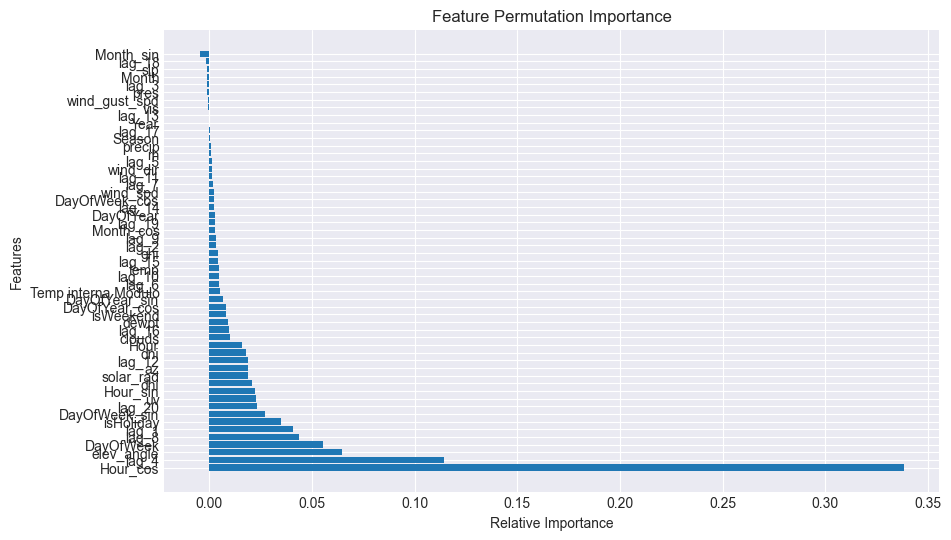

In [323]:
permutation_feature_importance(regressorXGBR, X_test.to_numpy(), y_test, np.array(col_names))

### Plot Prediction Results

In [324]:
plotPredictions(X_test_dates, y_pred, y_test)

In [325]:
plotPredictions(X_test_dates[:96*24], y_pred[:96*24], y_test[:96*24])

In [326]:
plotPredictions(X_test_dates[:96*7], y_pred[:96*7], y_test[:96*7])

In [327]:
print(f"Test Demand Min: {np.min(y_test)} - Max: {np.max(y_test)}")
print(f"Predicted Demand Min: {np.min(y_pred)} - Max: {np.max(y_pred)}")

Test Demand Min: 0.0 - Max: 0.9990345069810356
Predicted Demand Min: 2.0 - Max: 19.819793701171875
